In [41]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
import seaborn as sn
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
# NLP
from sklearn.feature_extraction.text import CountVectorizer # bag of words
# Machine Learning
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Read Data

In [2]:
home_path = os.path.expanduser("~")
# load the pre-processed data; stopwords removed, lowercase, lemmatisation
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text-preprocessed.csv'
df = pd.read_csv(fp)

A final clean to remove digits and single characters

In [3]:
%%time
to_remove = []
for i in range(len(df)):
    doc = ast.literal_eval(df['text'].iloc[i])
    for word in doc:
        if any(char.isdigit() for char in word):
            to_remove.append(word)
            
df['text'] = [[word for word in ast.literal_eval(doc) 
               if word not in set(to_remove) 
               and len(word) > 1] 
              for doc in df['text']]

display(df.head(1))
print(f'Number of documents: {len(df)}\nNumber of categories: {df["category"].unique()}')

,category,text
0,tech,"[tv, future, hand, viewer, home, theatre, syst..."


Number of documents: 2225
Number of categories: ['tech' 'business' 'sport' 'entertainment' 'politics']
CPU times: user 1min 57s, sys: 302 ms, total: 1min 57s
Wall time: 1min 57s


### Vectorisation of dataset
#### 1. Bag of Words

In [4]:
count_vect = CountVectorizer(binary=True)
bow_rep = count_vect.fit_transform(df['text'].astype(str))
# create dataframe
df_bow = pd.DataFrame(bow_rep.toarray(), columns=count_vect.get_feature_names_out())
print(f'There are {len(df_bow.columns)} tokens in the bag of words')
df_bow.head(1)

There are 23261 tokens in the bag of words


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row in the bag of words refers to a document, so the length of bag of words and the labelled data should be the same. So the 0 index in df_bow is the 0 index in the df. 

In [9]:
len(df_bow), len(df)

(2225, 2225)

#### 2. Modelling Data

Split the data into training and testing with sklearn

In [10]:
data, labels = df_bow, df['category']
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')

Training Data: 1668
Testing Data: 557


Let's look at some of the data and labels. You will see that BoW is something like [0 0 0 ... 0 1 0].

In [31]:
idxs = [1, 3, 10]
for i in idxs:
    print(f'BoW: {X_train.iloc[i].values}\nCategory: {y_train.iloc[i]}')
    print((X_train.iloc[i][X_train.iloc[i] == 1]).index.tolist())

BoW: [0 0 0 ... 0 0 0]
Category: business
['account', 'average', 'bear', 'big', 'borrow', 'britannia', 'build', 'customer', 'december', 'depend', 'deposit', 'earn', 'either', 'eligibility', 'entitle', 'interest', 'introduce', 'invest', 'investment', 'large', 'last', 'least', 'less', 'make', 'member', 'mortgage', 'much', 'must', 'pay', 'payment', 'payout', 'permanent', 'pibs', 'point', 'profit', 'qualify', 'receive', 'result', 'reward', 'rule', 'scheme', 'second', 'share', 'society', 'stop', 'strict', 'two', 'uk', 'unveil', 'wednesday', 'windfall', 'worth', 'year']
BoW: [0 0 0 ... 0 0 0]
Category: sport
['act', 'action', 'add', 'admit', 'agree', 'although', 'andy', 'anything', 'appoint', 'australian', 'back', 'basically', 'bbc', 'beat', 'begin', 'believe', 'berate', 'bit', 'blame', 'bloody', 'board', 'boost', 'bottom', 'camp', 'campese', 'cap', 'captain', 'care', 'castigate', 'champion', 'cheat', 'choice', 'class', 'clearcut', 'clive', 'coach', 'come', 'complaint', 'contemplate', 'cost'

In [47]:
print('Model Training time:')
log_reg = LogisticRegression() # instantiate a logistic regression model
%time log_reg.fit(X_train, y_train) # train the model(timing it with an IPython "magic command")
y_pred = log_reg.predict(X_test) # make class predictions for X_test

Model Training time:
CPU times: user 46 s, sys: 16.5 s, total: 1min 2s
Wall time: 8.8 s


#### 3. Accuracy Assessment

In [53]:
categories = df['category'].unique(); categories

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

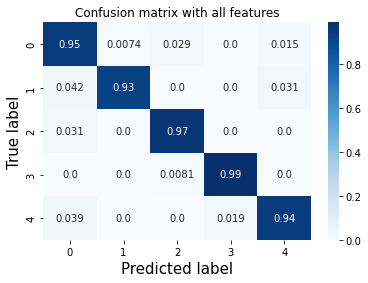

Accuracy:  0.9569120287253142


In [54]:
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues')
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()
    
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, 'Confusion matrix with all features')
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=y_pred))

The model did really well!

Which ones did it get wrong?

In [59]:
np.where(y_test != y_pred)

(array([  6,  22,  45,  61,  74,  88, 139, 155, 171, 174, 183, 209, 272,
        315, 348, 372, 377, 407, 414, 416, 424, 486, 499, 547]),)